# Sign Language Detetction

In [18]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,GlobalAveragePooling2D,Input,Activation
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split

import shutil
import random

## Will make a combined folder and then split  

In [3]:
folder_paths=['/kaggle/input/asl-dataset/asl_dataset',
              '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train']

test_folder='/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [4]:
output_path = '/kaggle/working/asl_combined'

os.makedirs(output_path, exist_ok=True)

for dataset_path in folder_paths:
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            out_label_path = os.path.join(output_path, label)
            os.makedirs(out_label_path, exist_ok=True)
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                if os.path.isfile(img_path):
                    dst = os.path.join(out_label_path, img_file)
                    shutil.copy(img_path, dst)

for img_file in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_file)
    if os.path.isfile(img_path):
        label = img_file.split('_')[0]  
        out_label_path = os.path.join(output_path, label)
        os.makedirs(out_label_path, exist_ok=True)
        dst = os.path.join(out_label_path, img_file)
        shutil.copy(img_path, dst)

## Files of images splitted into train and test dirs

In [5]:
root_dir = '/kaggle/working/asl_combined'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
              'space', 'nothing', 'delete'] + [chr(i) for i in range(ord('a'), ord('z') + 1)]

for cat in categories:
    os.makedirs(os.path.join(train_dir, cat), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cat), exist_ok=True)

def get_source_dirs_for_category(category):
    if category == 'delete':
        return [os.path.join(root_dir, 'del')]
    elif category in ['space', 'nothing'] or category.isdigit():
        return [os.path.join(root_dir, category)]
    else:
        dirs = []
        for case in [category.lower(), category.upper()]:
            full_path = os.path.join(root_dir, case)
            if os.path.isdir(full_path):
                dirs.append(full_path)
        return dirs

def find_image_files(category):
    files = []
    src_dirs = get_source_dirs_for_category(category)

    for src in src_dirs:
        for root, dirs, filenames in os.walk(src):
            if 'asl_dataset' in root:
                continue
            for f in filenames:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    files.append(os.path.join(root, f))

    return files

def move_files(category, split=0.8):
    files = find_image_files(category)

    if not files:
        print(f"[SKIPPED] No data found for '{category}'")
        return

    random.shuffle(files)
    split_idx = int(len(files) * split)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, category, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, category, os.path.basename(f)))

    print(f"[OK] {category}: {len(train_files)} train / {len(test_files)} test")

for cat in categories:
    move_files(cat)

print("All data split and copied into train and test")

[OK] 0: 56 train / 14 test
[OK] 1: 56 train / 14 test
[OK] 2: 56 train / 14 test
[OK] 3: 56 train / 14 test
[OK] 4: 56 train / 14 test
[OK] 5: 56 train / 14 test
[OK] 6: 56 train / 14 test
[OK] 7: 56 train / 14 test
[OK] 8: 56 train / 14 test
[OK] 9: 56 train / 14 test
[OK] space: 2400 train / 601 test
[OK] nothing: 2400 train / 601 test
[OK] delete: 2400 train / 600 test
[OK] a: 2456 train / 615 test
[OK] b: 2456 train / 615 test
[OK] c: 2456 train / 615 test
[OK] d: 2456 train / 615 test
[OK] e: 2456 train / 615 test
[OK] f: 2456 train / 615 test
[OK] g: 2456 train / 615 test
[OK] h: 2456 train / 615 test
[OK] i: 2456 train / 615 test
[OK] j: 2456 train / 615 test
[OK] k: 2456 train / 615 test
[OK] l: 2456 train / 615 test
[OK] m: 2456 train / 615 test
[OK] n: 2456 train / 615 test
[OK] o: 2456 train / 615 test
[OK] p: 2456 train / 615 test
[OK] q: 2456 train / 615 test
[OK] r: 2456 train / 615 test
[OK] s: 2456 train / 615 test
[OK] t: 2452 train / 614 test
[OK] u: 2456 train / 615 

## As images of digits have less files we will augement them to 100 samples and downsample the alphabets to remove class imbalance 

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img

src_dir = '/kaggle/working/train'
dst_dir = '/kaggle/working/final_train'
os.makedirs(dst_dir, exist_ok=True)

digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord('a'), ord('z') + 1)] + ['space', 'nothing', 'delete']

augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_and_save(image_path, target_dir, num_needed):
    image = load_img(image_path)
    x = img_to_array(image)
    x = x.reshape((1,) + x.shape)

    count = 0
    for batch in augmentor.flow(x, batch_size=1):
        save_path = os.path.join(target_dir, f"aug_{count}.png")
        save_img(save_path, batch[0])
        count += 1
        if count >= num_needed:
            break

for digit in digits:
    src_class = os.path.join(src_dir, digit)
    dst_class = os.path.join(dst_dir, digit)
    os.makedirs(dst_class, exist_ok=True)

    images = [os.path.join(src_class, f) for f in os.listdir(src_class) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    n_images = len(images)

    for img_path in images:
        shutil.copy(img_path, dst_class)

    if n_images < 100:
        needed = 100 - n_images
        for i in range(needed):
            base_image = random.choice(images)
            augment_and_save(base_image, dst_class, 1)
    else:

        selected = random.sample(images, 100)
        for img_path in selected:
            shutil.copy(img_path, dst_class)

for letter in letters:
    src_class = os.path.join(src_dir, letter)
    dst_class = os.path.join(dst_dir, letter)
    os.makedirs(dst_class, exist_ok=True)

    images = [os.path.join(src_class, f) for f in os.listdir(src_class) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected = random.sample(images, 100)
    for img_path in selected:
        shutil.copy(img_path, dst_class)

print("Created final_dataset with 100 images per class in /kaggle/working/final_dataset")

Created final_dataset with 100 images per class in /kaggle/working/final_dataset


In [7]:
img_size = 64
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    '/kaggle/working/final_train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = test_datagen.flow_from_directory(
    '/kaggle/working/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 3470 images belonging to 39 classes.
Found 17931 images belonging to 39 classes.


## Model building 

In [19]:
num_classes = len(train_gen.class_indices)
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    Conv2D(32, (3, 3), activation=None, input_shape=(64, 64, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation=None),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation=None),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 39)                  │           5,031 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,151 (1.63 MB)

 Trainable params: 425,959 (1.62 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
from tensorflow.keras.callbacks import Callback
epochs = 30  

In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen
)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.0447 - loss: 3.6280 - val_accuracy: 0.0335 - val_loss: 3.5355
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.1202 - loss: 3.1577 - val_accuracy: 0.0335 - val_loss: 4.1833
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.2927 - loss: 2.4438 - val_accuracy: 0.0345 - val_loss: 4.5132
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.4409 - loss: 1.8572 - val_accuracy: 0.1793 - val_loss: 3.2328
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5688 - loss: 1.4128 - val_accuracy: 0.4864 - val_loss: 1.8612
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6734 - loss: 1.0632 - val_accuracy: 0.7154 - val_loss: 1.0319
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7537 - loss: 0.8110 - val_accuracy: 0.6910 - val_loss: 1.0027
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7705 - loss: 0

Found 17931 images belonging to 39 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


561/561 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step


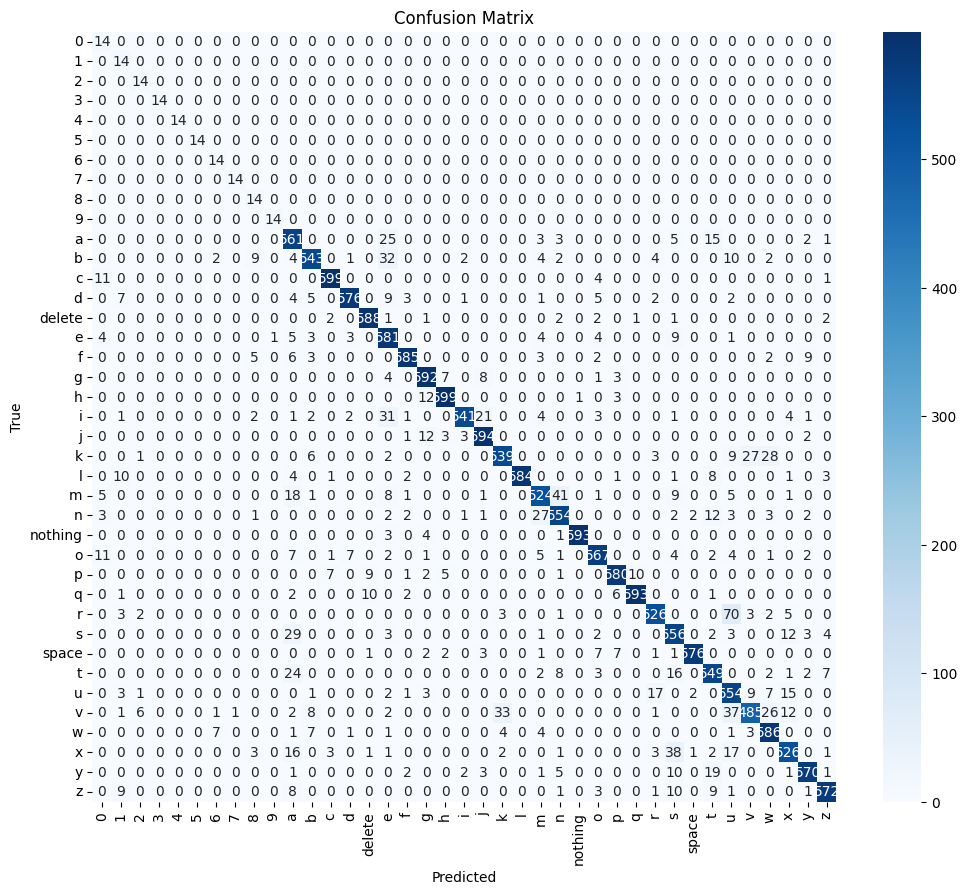

              precision    recall  f1-score   support

           0       0.29      1.00      0.45        14
           1       0.29      1.00      0.44        14
           2       0.58      1.00      0.74        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        14
           6       0.58      1.00      0.74        14
           7       0.93      1.00      0.97        14
           8       0.41      1.00      0.58        14
           9       0.93      1.00      0.97        14
           a       0.81      0.91      0.86       615
           b       0.94      0.88      0.91       615
           c       0.98      0.97      0.98       615
           d       0.98      0.94      0.96       615
      delete       0.97      0.98      0.97       600
           e       0.82      0.94      0.88       615
           f       0.97      0.95      0.96       615
           g       0.94    

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

test_gen = test_datagen.flow_from_directory(
    '/kaggle/working/test',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

y_true = test_gen.classes
y_pred = model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=labels))

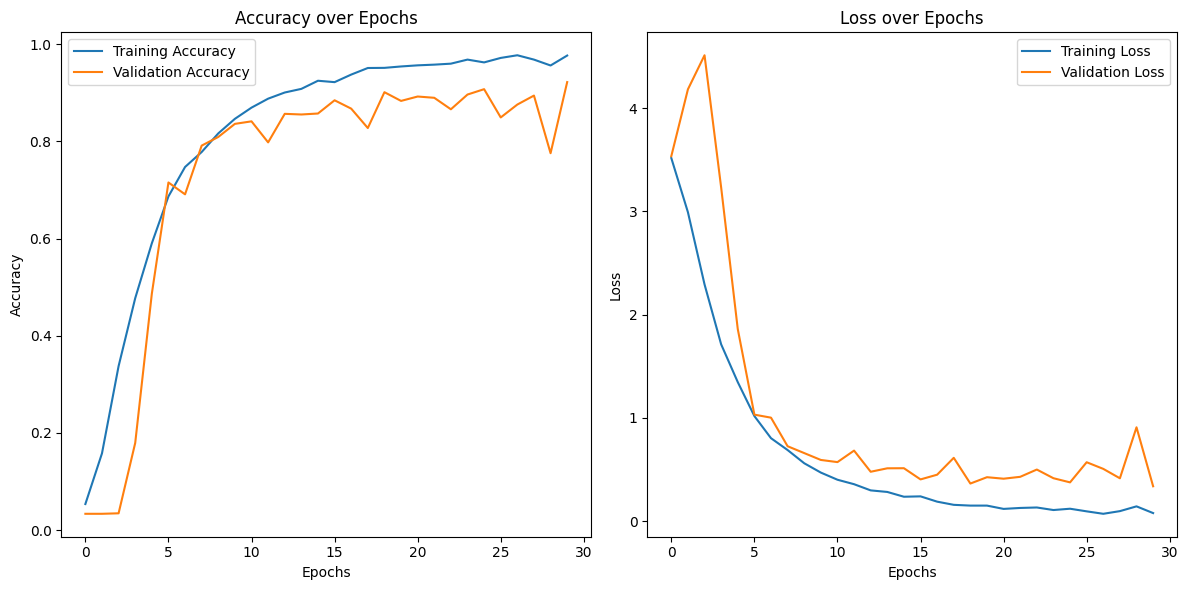

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
model.save('asl_vision_model.h5')